In [77]:
import torch
import torch.nn as nn
import numpy as np
import tqdm

In [78]:
class RNNCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True, activation='tanh'):
    super(RNNCell, self).__init__()
    # Init Parameters
    self.hidden_size = hidden_size
    self.activation = activation
    self.bias = bias

    # Cell
    self.i2h = nn.Linear(input_size+hidden_size, hidden_size, bias=bias)
  
  
  def forward(self, input_tensor, hidden_tensor=None):
    """
    Inputs:
      input_tensor -> (batch_size, input_size)
      hidden_tensor -> (batch_size, hidden_size)
    Outputs:
      hidden_tensor -> (batch_size, hidden_size)
    """
    if hidden_tensor is None:
      hidden_tensor = torch.zeros(input_tensor.size(0), self.hidden_size)

    combined_tensor = torch.cat((input_tensor, hidden_tensor), 1)
    hidden = self.i2h(combined_tensor)
    return hidden

def test_rnn():
  input_size = 100
  hidden_size = 32
  batch_size = 32
  sample = torch.randn(batch_size, input_size)
  sample2 = torch.randn(batch_size, input_size)
  rnn = RNNCell(input_size, hidden_size)
  hidden = rnn(sample)
  hidden = rnn(sample2, hidden)
  
test_rnn()

In [79]:
class SimpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1, bias=True, activation='tanh') -> None:
    super().__init__()
    # Params
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.bias = bias
    self.activation = activation
    self.num_layers = num_layers

    # Single Layer
    self.rnn_cells = nn.ModuleList()
    for i in range(num_layers):
      if i == 0:
        self.rnn_cells.append(
          RNNCell(self.input_size, self.hidden_size, self.bias, self.activation)
        )
      else:
        self.rnn_cells.append(
          RNNCell(self.hidden_size, self.hidden_size, self.bias, self.activation)
        )
    # Output Layer
    self.fc = nn.Linear(self.hidden_size, self.output_size)
    self.softmax = nn.LogSoftmax(dim=1)
      
  def forward(self, input_tensor, hidden_tensors):
    for i in range(self.num_layers):
      if i == 0:
        hidden_tensors[i] = self.rnn_cells[i](input_tensor, hidden_tensors[i])
      else:
        hidden_tensors[i] = self.rnn_cells[i](hidden_tensors[i-1], hidden_tensors[i])
    output = self.fc(hidden_tensors[-1])
    output = self.softmax(output)
    return output, hidden_tensors
    

# sample_image = torch.randn(32, 26)
# hidden_tensors = torch.randn(3, 32, 128)
# rnn = SimpleRNN(26, 128, 26, num_layers=3)
# output, hidden = rnn(sample_image, hidden_tensors)
# print(output.size(), hidden.size())

In [83]:
import string
import random
import unicodedata
import os

# parameters
alphabets = string.ascii_letters + " .,;'"
data_path = './data/names/'
total_chars = len(alphabets)

# some functions
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in alphabets
  )

def word_to_tensor(word):
  tensor = torch.zeros(len(word), 1, total_chars)
  for i, letter in enumerate(word):
    tensor[i][0][alphabets.find(letter)] = 1
  return tensor

def random_example(languages, data):
  language = random.choice(languages)
  language_tensor = torch.tensor([languages.index(language)])
  word = random.choice(data[language])
  return language_tensor, word_to_tensor(word), word

languages = []
data = {}
for file_name in os.listdir(data_path):
  category = file_name.split('.')[0]
  file = open(data_path+file_name, 'r', encoding='utf-8')
  languages.append(category)
  data[category] = []
  for line in file.read().splitlines():
    data[category].append(unicode_to_ascii(line))

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = len(alphabets)
output_size = len(languages)
hidden_size = 128
batch_size = 1
learning_rate = 0.005
iterations = 100000
num_layers = 3
rnn = SimpleRNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

  0%|          | 0/100000 [00:00<?, ?it/s]

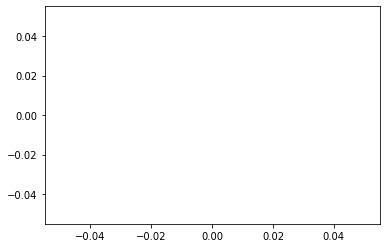

 10%|▉         | 9997/100000 [01:00<09:48, 152.94it/s]

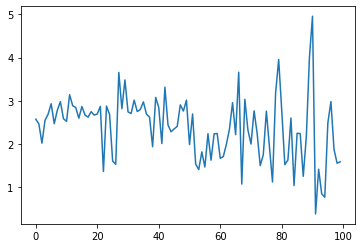

 20%|█▉        | 19991/100000 [02:03<08:06, 164.45it/s]

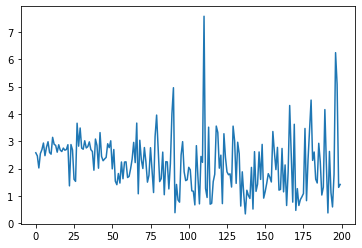

 30%|██▉       | 29996/100000 [03:06<06:41, 174.38it/s]

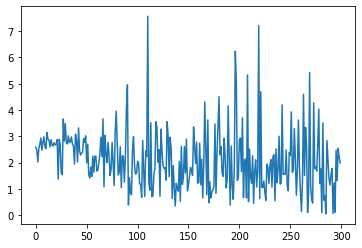

 40%|███▉      | 39996/100000 [04:06<06:00, 166.65it/s]

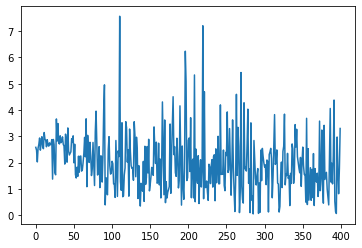

 50%|████▉     | 49983/100000 [05:07<04:55, 169.49it/s]

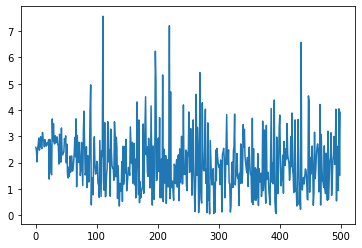

 60%|█████▉    | 59990/100000 [06:09<03:52, 172.40it/s]

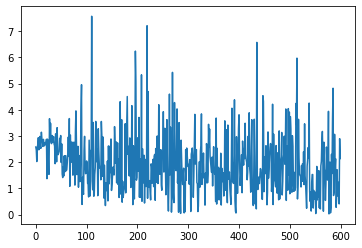

 70%|██████▉   | 69994/100000 [07:09<02:52, 173.79it/s]

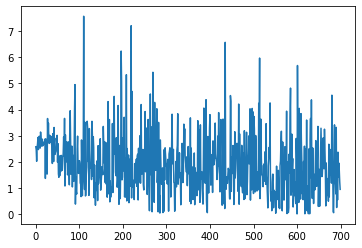

 80%|███████▉  | 79987/100000 [08:08<01:54, 175.55it/s]

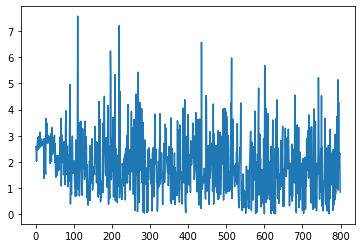

 90%|████████▉ | 89998/100000 [09:07<01:01, 163.94it/s]

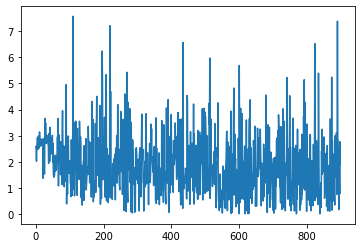

100%|██████████| 100000/100000 [10:06<00:00, 164.78it/s]


In [85]:
import matplotlib.pyplot as plt
from tqdm import tqdm
losses = []
curr_loss = 0
for i in tqdm(range(iterations)):
  language, word, _ = random_example(languages, data)
  hidden = torch.randn(rnn.num_layers, batch_size, hidden_size)
  for letter in word:
    output, hidden = rnn(letter, hidden)
  loss = criterion(output, language)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i%10000 == 0:
    with torch.no_grad():
      plt.plot(losses)
      plt.show()
  if i%100 == 0:
    losses.append(loss.item())

In [116]:
def predict(word):
  with torch.no_grad():
    word_tensor = word_to_tensor(word)
    hidden = torch.randn(rnn.num_layers, batch_size, hidden_size)
    for letter in word_tensor:
      output, hidden = rnn(letter, hidden)
    guess = torch.argmax(output)
    # print(f'Word: {word}, Predicted: {languages[guess.item()]}')
    return guess.item()

In [117]:
predict("wing")

1

In [130]:
count = 0
for i in tqdm(range(100)):
  language, word, realword = random_example(languages, data)
  if language.item() == predict(realword):
    count += 1
print('Accuracy : ', count)

100%|██████████| 100/100 [00:00<00:00, 342.21it/s]

Accuracy :  43
